In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.3.11  |       h06a4308_0         127 KB
    certifi-2024.2.2           |  py310h06a4308_0         159 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/li

In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d91007f2-38e3-4bab-a2f8-a276b3d2b123;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 407ms :: artifacts dl 28ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

24/04/05 12:47:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [4]:
!aws s3 ls s3://team4-crypto/

                           PRE comments-crypto-doge/
                           PRE merged_crypto_doge/
                           PRE submission-crypto-doge/
                           PRE submission_doge_allreddit/
2024-03-30 18:48:50   27266475 kaggle_doge_reddit_post_2021.csv


In [5]:
merged = spark.read.parquet("s3a://team4-crypto/merged_crypto_doge", header=True)

24/04/05 12:47:53 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
merged.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- author: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- title: string (nullable = true)
 |-- com_subreddit: string (nullable = true)
 |-- com_subreddit_id: string (nullable = true)
 |-- com_id: string (nullable = true)
 |-- com_created_utc: long (nullable = true)
 |-- com_author: string (nullable = true)
 |-- com_link_id: string (nullable = true)
 |-- com_score: long (nullable = true)
 |-- com_body: string (nullable = true)
 |-- com_submis_id: string (nullable = true)



In [7]:
# imports

from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.functions import from_unixtime, to_date, col

## Unique active days per author - post + comment

In [8]:
# Combining post and comment dates into one column for counting unique active days

posts_dates = merged.select(f.col("author"),\
                                       f.to_date(f.from_unixtime("created_utc")).alias("activity_date")).distinct()

comments_dates = merged.select(f.col("com_author").alias("author"),\
                               f.to_date(f.from_unixtime("com_created_utc")).alias("activity_date"))


unique_active_days = posts_dates.unionByName(comments_dates) \
                                 .groupBy("author") \
                                 .agg(f.countDistinct("activity_date").alias("unique_active_days"))


In [9]:
unique_active_days.orderBy(f.col('unique_active_days').desc()).show()

+--------------------+------------------+
|              author|unique_active_days|
+--------------------+------------------+
|           [deleted]|               378|
|            42points|               279|
|       AutoModerator|               278|
|            Fulvio55|               278|
|           liquid_at|               278|
|     RepostSleuthBot|               260|
|           rizzo49er|               253|
|         Dogekaliber|               238|
|           Jimbo4901|               237|
|     masterbatesAlot|               230|
|        Mananimalism|               220|
|     Mundane_Ad_3106|               204|
|           sodogetip|               198|
|         KingCoin187|               190|
|      theDOGEdolphin|               190|
|          terran7777|               182|
|        MokolokoPlus|               179|
| Good_Extension_9642|               174|
|Necessary-Pension224|               172|
|           kirtash93|               171|
+--------------------+------------

### Comments made by founder of dogecoin u/billymarkus2k

In [107]:
merged.filter((merged.com_author == 'billymarkus2k')\
              |( merged.author == 'billymarkus2k'))\
.select('author','com_subreddit','num_comments','com_body').show(20, truncate=False)

+------------------+-------------+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|author            |com_subreddit|num_comments|com_body                                                                                                                                                                                                                                                                                                                                                                                                                  

---


## Daily and Monthly Active Users

In [55]:
merged.select("id","created_utc", "author", "com_created_utc","com_author").show()

+-------+-----------+--------------------+---------------+--------------------+
|     id|created_utc|              author|com_created_utc|          com_author|
+-------+-----------+--------------------+---------------+--------------------+
|10007a6| 1672510767|     SurelyGeorgeZip|     1672510767|       AutoModerator|
|1015i59| 1672640995|        DavisSsS1373|           null|                null|
|101a0ol| 1672657440|     cryptoheimdallr|     1672678000|         MissGone300|
|101a0ol| 1672657440|     cryptoheimdallr|     1672679581|        voterosticon|
|101a0ol| 1672657440|     cryptoheimdallr|     1672710393|          M-Apple123|
|101i88s| 1672680620|         TerminatorJ|     1672744879|           SirEffKay|
|101i88s| 1672680620|         TerminatorJ|     1672680861|           [deleted]|
|101i88s| 1672680620|         TerminatorJ|     1672687419|     masterbatesAlot|
|101o767| 1672694728|         ogwarpriest|           null|                null|
|101vv9t| 1672713843|Sea_Yogurtcloset749

In [10]:
# Aggregate posts by day and author, counting unique ids
posts_per_day_author = merged.groupBy("created_utc", "author")\
                             .agg(f.countDistinct("id").alias("num_posts"))\
                             .withColumnRenamed("author", "post_author")

In [11]:
posts_per_day_author.show()

+-----------+--------------------+---------+
|created_utc|         post_author|num_posts|
+-----------+--------------------+---------+
| 1669641784| Frequent-Earth-1661|        1|
| 1645625055|         Steven44323|        1|
| 1641980400|     SeaScarcity2110|        1|
| 1668238415|Longjumping-Creme952|        1|
| 1641348234|   BlazingHotFireFox|        1|
| 1672961310|              JayTP-|        1|
| 1642089535|           achette98|        1|
| 1645145150|           [deleted]|        1|
| 1648070394|          R1presents|        1|
| 1650909177|             Fahjahh|        1|
| 1646500633|            Gmotunde|        1|
| 1645999220|            Undtaser|        1|
| 1650067087|           [deleted]|        1|
| 1651052834|            42points|        1|
| 1659667239|           [deleted]|        1|
| 1672096725|           BzKDragon|        1|
| 1645676269|           [deleted]|        1|
| 1654182853|         ShipDue7617|        1|
| 1668244428|            42points|        1|
| 16512321

In [102]:
merged.filter(col("com_created_utc").isNull()).count()

15893

These would be posts without any comments

In [12]:
filtered_merged = merged.filter(f.col("com_created_utc").isNotNull())


comments_per_day_author = filtered_merged.groupBy("com_created_utc", "com_author").count()\
                                         .withColumnRenamed("count", "num_comments")\
                                         .withColumnRenamed("com_author", "comment_author")

comments_per_day_author.show()

+---------------+--------------------+------------+
|com_created_utc|      comment_author|num_comments|
+---------------+--------------------+------------+
|     1673000338|            BriBumer|           1|
|     1673355153|         MissionDoge|           1|
|     1673662151|        Signiference|           1|
|     1673674375|            Kino1337|           1|
|     1673789080|        CRYPTOGLYPHi|           1|
|     1673986373|Mediocre-Action-2958|           1|
|     1674034430|   reddit-is-so-nice|           1|
|     1674410348|           [deleted]|           1|
|     1674670729|Melodic_Assistance84|           1|
|     1641123049|Traditional_Fruit_40|           1|
|     1641128722|Dependent-Plenty-222|           1|
|     1641172396|    Informal-Tie4617|           1|
|     1641315406|           wylie2020|           1|
|     1641291951|           [deleted]|           1|
|     1641249254|           FSantos09|           1|
|     1641323877|           [deleted]|           1|
|     164348

In [13]:
joined_df = posts_per_day_author.join(
    comments_per_day_author,
    (posts_per_day_author.created_utc == comments_per_day_author.com_created_utc) & 
    (posts_per_day_author.post_author == comments_per_day_author.comment_author),
    "outer"  
)

# Show the resulting DataFrame to verify the join
joined_df.show()

+-----------+---------------+---------+---------------+------------------+------------+
|created_utc|    post_author|num_posts|com_created_utc|    comment_author|num_comments|
+-----------+---------------+---------+---------------+------------------+------------+
| 1640995576|   BokChoySlaps|        1|           null|              null|        null|
|       null|           null|     null|     1640996143| dontlookformehere|           1|
|       null|           null|     null|     1640996262|            Mau120|           1|
|       null|           null|     null|     1640996267|    purpledream999|           1|
|       null|           null|     null|     1640996278|      Real-Toe2749|           1|
|       null|           null|     null|     1640996294|       wetmanbrown|           1|
|       null|           null|     null|     1640996363|      deathtolucky|           1|
|       null|           null|     null|     1640996431| TrafficConeWriter|           1|
|       null|           null|   

In [14]:
merged_with_date_and_author2 = joined_df.withColumn(
    "udate",
    f.coalesce(
        f.to_date(f.from_unixtime("created_utc")),
        f.to_date(f.from_unixtime("com_created_utc"))
    )
).withColumn(
    "uauthor",
    f.coalesce(f.col("post_author"), f.col("comment_author"))
)

merged_with_date_and_author2 = merged_with_date_and_author2.withColumn("day", f.dayofmonth("udate"))\
                           .withColumn("month", f.month("udate"))\
                           .withColumn("year", f.year("udate"))

In [15]:
merged_with_date_and_author2.show(5)

+-----------+------------+---------+---------------+-----------------+------------+----------+-----------------+---+-----+----+
|created_utc| post_author|num_posts|com_created_utc|   comment_author|num_comments|     udate|          uauthor|day|month|year|
+-----------+------------+---------+---------------+-----------------+------------+----------+-----------------+---+-----+----+
| 1640995576|BokChoySlaps|        1|           null|             null|        null|2022-01-01|     BokChoySlaps|  1|    1|2022|
|       null|        null|     null|     1640996143|dontlookformehere|           1|2022-01-01|dontlookformehere|  1|    1|2022|
|       null|        null|     null|     1640996262|           Mau120|           1|2022-01-01|           Mau120|  1|    1|2022|
|       null|        null|     null|     1640996267|   purpledream999|           1|2022-01-01|   purpledream999|  1|    1|2022|
|       null|        null|     null|     1640996278|     Real-Toe2749|           1|2022-01-01|     Real-

In [16]:
new_daily = merged_with_date_and_author2.select("year", "month", "day", "udate", "uauthor", "num_posts","num_comments").na.fill(0)

In [17]:
new_daily.show()

+----+-----+---+----------+------------------+---------+------------+
|year|month|day|     udate|           uauthor|num_posts|num_comments|
+----+-----+---+----------+------------------+---------+------------+
|2022|    1|  1|2022-01-01|      BokChoySlaps|        1|           0|
|2022|    1|  1|2022-01-01| dontlookformehere|        0|           1|
|2022|    1|  1|2022-01-01|            Mau120|        0|           1|
|2022|    1|  1|2022-01-01|    purpledream999|        0|           1|
|2022|    1|  1|2022-01-01|      Real-Toe2749|        0|           1|
|2022|    1|  1|2022-01-01|       wetmanbrown|        0|           1|
|2022|    1|  1|2022-01-01|      deathtolucky|        0|           1|
|2022|    1|  1|2022-01-01| TrafficConeWriter|        0|           1|
|2022|    1|  1|2022-01-01|      Real-Toe2749|        0|           1|
|2022|    1|  1|2022-01-01|        bsmith2580|        0|           1|
|2022|    1|  1|2022-01-01|         [deleted]|        0|           1|
|2022|    1|  1|2022

In [18]:
new_daily_active_users = new_daily.groupBy("udate", "uauthor").count().withColumnRenamed("count", "num_posts_comm")
new_monthly_active_users = new_daily.groupBy("year","month", "uauthor").count().withColumnRenamed("count", "num_posts_comm")

In [19]:
new_daily_active_users.show(5)

+----------+--------------------+--------------+
|     udate|             uauthor|num_posts_comm|
+----------+--------------------+--------------+
|2022-01-01|       ricardovarona|             1|
|2022-01-01|        furryaltowo1|             8|
|2022-01-01|            Brimmert|             1|
|2022-01-01|Effective_Explorer95|             2|
|2022-01-01|         riffahs_ira|             1|
+----------+--------------------+--------------+
only showing top 5 rows



In [20]:
new_monthly_active_users.show(5)

+----+-----+-----------+--------------+
|year|month|    uauthor|num_posts_comm|
+----+-----+-----------+--------------+
|2022|    1|MightyMoria|             1|
|2022|    1|  MilchDeep|             2|
|2022|    1|    btopski|             2|
|2022|    1|     Joroda|             5|
|2022|    1| CryptoRipz|             7|
+----+-----+-----------+--------------+
only showing top 5 rows



In [21]:
new_daily_active_users.select("udate").distinct().count()

395

In [22]:
new_daily_active_total = new_daily_active_users.groupBy("udate").count().withColumnRenamed("count", "daily_users")

In [23]:
new_monthly_active_total = new_monthly_active_users.groupBy("year","month").count()\
.withColumnRenamed("count", "monthly_users")

In [24]:
new_daily_active_total.show()

+----------+-----------+
|     udate|daily_users|
+----------+-----------+
|2022-03-28|       1521|
|2022-07-31|          3|
|2022-08-02|        509|
|2022-11-29|        969|
|2022-12-25|        460|
|2022-07-27|          6|
|2022-01-31|          5|
|2022-05-19|          6|
|2022-06-18|          8|
|2022-06-22|          5|
|2022-03-16|        911|
|2022-06-06|        648|
|2022-11-21|        466|
|2022-07-07|        617|
|2022-03-12|        999|
|2022-03-15|        795|
|2022-04-02|       2356|
|2022-04-10|        870|
|2022-12-09|        873|
|2022-12-02|        475|
+----------+-----------+
only showing top 20 rows



In [25]:
new_monthly_active_total.show(5)

+----+-----+-------------+
|year|month|monthly_users|
+----+-----+-------------+
|2022|   10|         6086|
|2022|    2|        18767|
|2022|    7|         6138|
|2022|   11|        13719|
|2022|    3|        19635|
+----+-----+-------------+
only showing top 5 rows



In [26]:
new_daily_active_total.select("udate").distinct().count()

395

In [155]:
new_daily_active_total.orderBy(col('daily_users').desc()).show()

+----------+-----------+
|     udate|daily_users|
+----------+-----------+
|2022-03-07|       3500|
|2022-03-06|       3129|
|2022-01-14|       2782|
|2022-01-11|       2739|
|2022-01-05|       2712|
|2022-01-13|       2655|
|2022-04-02|       2356|
|2022-01-08|       2277|
|2022-02-22|       2173|
|2022-01-10|       2154|
|2022-02-07|       2146|
|2022-04-25|       2073|
|2022-04-26|       2028|
|2022-04-01|       2013|
|2022-01-06|       1985|
|2022-01-02|       1775|
|2022-06-13|       1757|
|2022-02-05|       1751|
|2022-01-09|       1736|
|2022-02-13|       1636|
+----------+-----------+
only showing top 20 rows



In [27]:
new_daily_pd = new_daily_active_total.toPandas()

In [147]:
!pip install scienceplots


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [29]:
new_monthly_pd = new_monthly_active_total.toPandas()

<Figure size 1400x700 with 0 Axes>

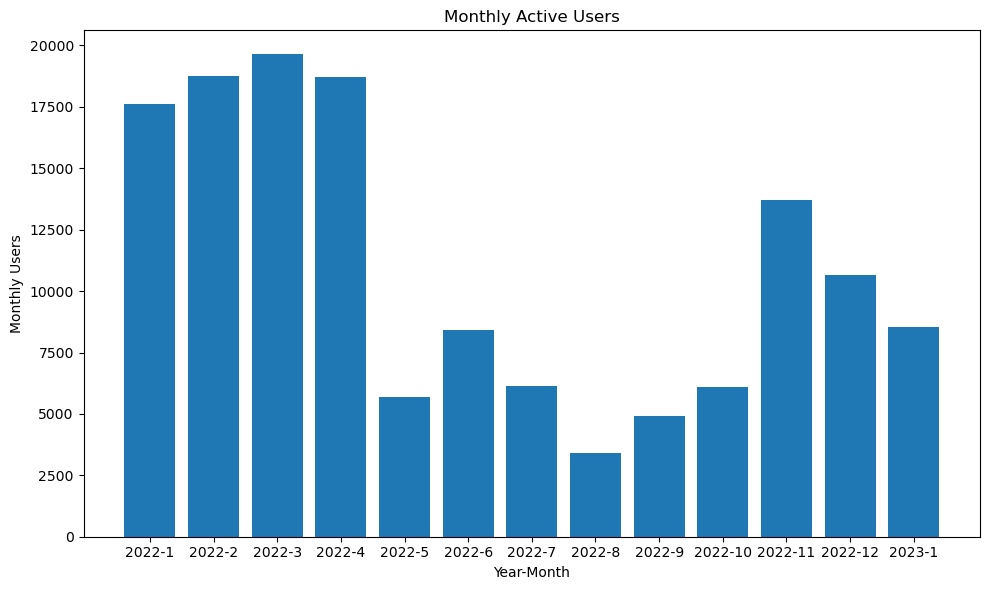

In [159]:
import pandas as pd
with plt.style.context(['science', 'high-vis']):
    # Configure plot settings
    plt.figure(figsize=(14, 7))
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.title_fontsize'] = 18
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.weight'] = 'normal'



new_monthly_pd['year_month'] = new_monthly_pd["year"].astype(str) + "-" + new_monthly_pd["month"].astype(str)

new_monthly_pd = new_monthly_pd.sort_values(by=['year', "month"])


plt.figure(figsize=(10, 6))
plt.bar(new_monthly_pd['year_month'], new_monthly_pd['monthly_users'])
plt.title('Monthly Active Users')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Users')

plt.tight_layout()
plt.savefig('../../website-source/plots/EDA/Q2/2_2.png')
plt.show()

<Figure size 1400x700 with 0 Axes>

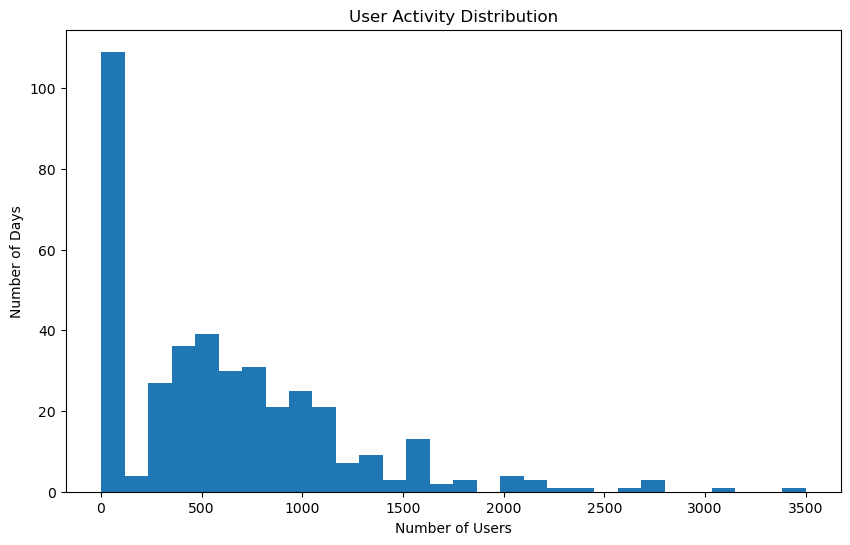

In [154]:
# Plot for number of days users are active

with plt.style.context(['science', 'high-vis']):
    # Configure plot settings
    plt.figure(figsize=(14, 7))
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.title_fontsize'] = 18
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.weight'] = 'normal'



# Plotting a histogram of 'daily number of users'
plt.figure(figsize=(10, 6))
plt.hist(new_daily_pd['daily_users'], bins=30, color='tab:blue')
plt.title('User Activity Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Number of Days')
#plt.grid(axis='y', alpha=0.75)
plt.show()

Table of User activity

In [32]:
user_activity = new_daily.withColumn("total_activities", f.col("num_posts") + f.col("num_comments"))

In [33]:
user_activity.show(5)

+----+-----+---+----------+-----------------+---------+------------+----------------+
|year|month|day|     udate|          uauthor|num_posts|num_comments|total_activities|
+----+-----+---+----------+-----------------+---------+------------+----------------+
|2022|    1|  1|2022-01-01|     BokChoySlaps|        1|           0|               1|
|2022|    1|  1|2022-01-01|dontlookformehere|        0|           1|               1|
|2022|    1|  1|2022-01-01|           Mau120|        0|           1|               1|
|2022|    1|  1|2022-01-01|   purpledream999|        0|           1|               1|
|2022|    1|  1|2022-01-01|     Real-Toe2749|        0|           1|               1|
+----+-----+---+----------+-----------------+---------+------------+----------------+
only showing top 5 rows



In [34]:
# Based on the number of posts and comments by each user

top_authors = user_activity.groupBy("uauthor")\
                .agg(f.sum("total_activities").alias("sum_total_activities"))\
                .orderBy(f.col("sum_total_activities").desc())

In [35]:
top_authors.show(10)

+-------------------+--------------------+
|            uauthor|sum_total_activities|
+-------------------+--------------------+
|          [deleted]|              183919|
|          liquid_at|                8586|
|           Fulvio55|                4386|
|          sodogetip|                4000|
|    RepostSleuthBot|                2083|
|freebanbot_squirrel|                2067|
|      AutoModerator|                1983|
|  freebanbot_spider|                1907|
|        KingCoin187|                1748|
|    masterbatesAlot|                1643|
+-------------------+--------------------+
only showing top 10 rows



In [36]:
total_activities_sum = top_authors.agg(f.sum("sum_total_activities").alias("total")).collect()[0]["total"]

In [37]:
top_authors_with_percentage = top_authors.withColumn(
    "percentage_of_total_activities",
    (f.col("sum_total_activities") / total_activities_sum) * 100
)

# Show the result
top_authors_with_percentage.show()

+-------------------+--------------------+------------------------------+
|            uauthor|sum_total_activities|percentage_of_total_activities|
+-------------------+--------------------+------------------------------+
|          [deleted]|              183919|            29.690597495851172|
|          liquid_at|                8586|            1.3860638112396118|
|           Fulvio55|                4386|            0.7080451754131071|
|          sodogetip|                4000|            0.6457320341204806|
|    RepostSleuthBot|                2083|            0.3362649567682403|
|freebanbot_squirrel|                2067|            0.3336820286317584|
|      AutoModerator|                1983|            0.3201216559152283|
|  freebanbot_spider|                1907|            0.3078527472669392|
|        KingCoin187|                1748|            0.2821848989106501|
|    masterbatesAlot|                1643|           0.26523443301498745|
|        Dogekaliber|                1

In [120]:
top_authors_with_percentage.count()

87743

In [39]:
# users with the most number of posts
merged.groupBy('author').agg(f.countDistinct("id").alias("posts")).orderBy(col("posts").desc()).show(10)

+-----------------+-----+
|           author|posts|
+-----------------+-----+
|        [deleted]| 7983|
|        rizzo49er|  492|
|         42points|  279|
|  SeaScarcity2110|  277|
|   TheDogeAcademy|  270|
|  Bluesmantexas89|  208|
|   Full_Moon_LoBo|  203|
|        Yellomelw|  191|
|     Mananimalism|  166|
|HumanbyNature1717|  157|
+-----------------+-----+
only showing top 10 rows



In [40]:
# users with the most number of posts agg by subreddit
merged.groupBy('subreddit', 'author').agg(f.countDistinct("id").alias("posts")).orderBy(col("posts").desc()).show(10)

+--------------+---------------+-----+
|     subreddit|         author|posts|
+--------------+---------------+-----+
|      dogecoin|      [deleted]| 7582|
|      dogecoin|      rizzo49er|  492|
|CryptoCurrency|      [deleted]|  401|
|      dogecoin|       42points|  279|
|      dogecoin|SeaScarcity2110|  277|
|      dogecoin| TheDogeAcademy|  270|
|      dogecoin|Bluesmantexas89|  208|
|      dogecoin| Full_Moon_LoBo|  203|
|      dogecoin|      Yellomelw|  190|
|      dogecoin|   Mananimalism|  166|
+--------------+---------------+-----+
only showing top 10 rows



In [41]:
# users with the most number of comments
merged.groupBy('com_author').agg(f.count("*").alias("comments")).orderBy(col("comments").desc()).show(10)

+-------------------+--------+
|         com_author|comments|
+-------------------+--------+
|          [deleted]|  175936|
|               null|   15893|
|          liquid_at|    8584|
|           Fulvio55|    4366|
|          sodogetip|    4000|
|    RepostSleuthBot|    2083|
|freebanbot_squirrel|    2067|
|      AutoModerator|    1983|
|  freebanbot_spider|    1907|
|    masterbatesAlot|    1626|
+-------------------+--------+
only showing top 10 rows



In [42]:
# users with the most number of comments agg by subreddit
merged.groupBy('com_subreddit', 'com_author').agg(f.count("*").alias("comments")).orderBy(col("comments").desc()).show(10)

+--------------+---------------+--------+
| com_subreddit|     com_author|comments|
+--------------+---------------+--------+
|      dogecoin|      [deleted]|  158109|
|CryptoCurrency|      [deleted]|   17827|
|          null|           null|   15893|
|      dogecoin|      liquid_at|    8454|
|      dogecoin|       Fulvio55|    4356|
|      dogecoin|      sodogetip|    4000|
|      dogecoin|RepostSleuthBot|    2083|
|      dogecoin|masterbatesAlot|    1598|
|      dogecoin|    KingCoin187|    1592|
|      dogecoin|    Dogekaliber|    1535|
+--------------+---------------+--------+
only showing top 10 rows



## By total scores


In [43]:
posts = merged.select('subreddit', 'id', 'created_utc', 'author', 'is_self', 'num_comments', 'score', 'selftext', 'title' )

In [44]:
posts.count()

587972

In [45]:
posts.distinct().count()

47373

In [46]:
posts_only = posts.distinct()

In [47]:
posts_only_grp = posts_only.groupBy('subreddit','author').agg(f.sum('num_comments').alias('comments'),\
                                             f.sum('score').alias('total_score'))\
.orderBy(f.col("total_score").desc())

### To check correltions between number of comments and the score

In [58]:
posts_only_corr = posts_only.select('subreddit', 'id', 'created_utc', 'num_comments', 'score') 

In [60]:
posts_only_corr.orderBy(f.col("score").desc()).show(5)

+--------------+-------+-----------+------------+-----+
|     subreddit|     id|created_utc|num_comments|score|
+--------------+-------+-----------+------------+-----+
|      dogecoin|106x3lz| 1673218577|         233|17125|
|      dogecoin| t0l4w4| 1645736067|         294| 7330|
|      dogecoin| rv0sry| 1641213441|         328| 7197|
|CryptoCurrency| sydqg4| 1645502336|        1660| 6937|
|      dogecoin| sqnk8x| 1644657384|         505| 6150|
+--------------+-------+-----------+------------+-----+
only showing top 5 rows



In [62]:
# 11226 - max comments, 17125 - max score

In [54]:
posts_only_corr.filter(posts_only_corr.subreddit == 'dogecoin').stat.corr("num_comments", "score")

0.42484943919930135

In [55]:
posts_only_corr.filter(posts_only_corr.subreddit == 'CryptoCurrency').stat.corr("num_comments", "score")

0.4303048905457407

In [56]:
posts_only_corr_pd = posts_only_corr.toPandas()

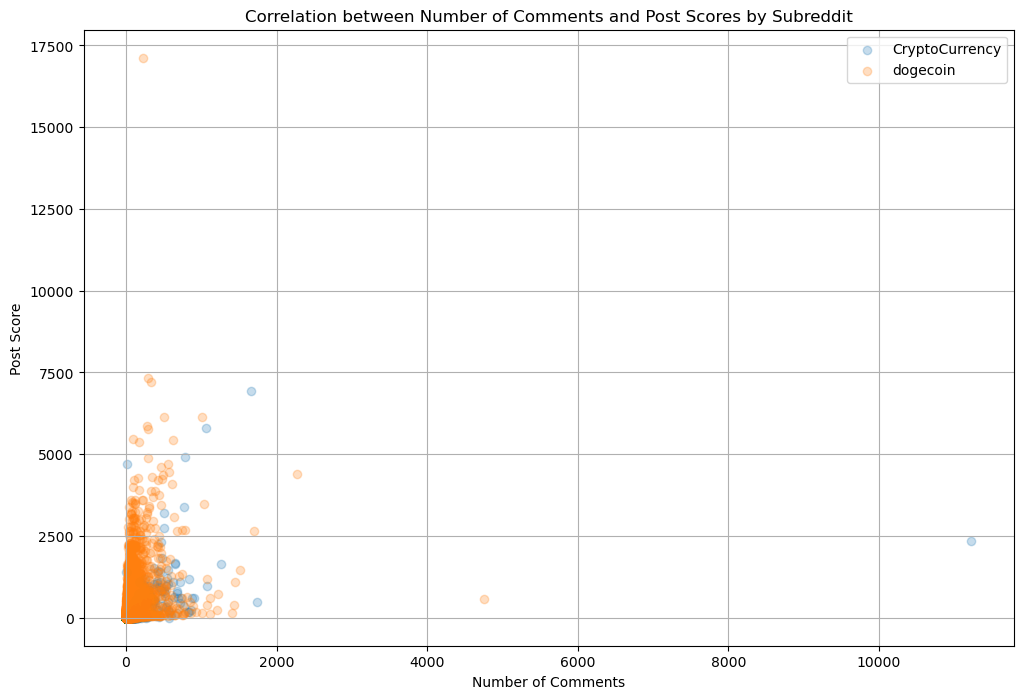

In [68]:
import matplotlib.pyplot as plt
import numpy as np


subreddits = ['CryptoCurrency', 'dogecoin']


# Plot scatter plots for each subreddit
plt.figure(figsize=(12, 8))

for subreddit in subreddits:
    subset = posts_only_corr_pd[posts_only_corr_pd['subreddit'] == subreddit]
    
    # Calculate the line of best fit
    slope, intercept = np.polyfit(subset['num_comments'], subset['score'], 1)
    x_vals = np.array([subset['num_comments'].min(), subset['num_comments'].max()])
    y_vals = intercept + slope * x_vals
    
    # Scatter plot for the subreddit
    plt.scatter(subset['num_comments'], subset['score'], alpha=0.25, label=subreddit)
    #plt.plot(x_vals, y_vals, label=f"Best Fit: {subreddit}")
    
plt.title('Correlation between Number of Comments and Post Scores by Subreddit')
plt.xlabel('Number of Comments')
plt.ylabel('Post Score')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
comments = merged.select('com_subreddit', 'com_id', 'com_created_utc', 'com_author', 'com_link_id', \
                         'com_score', 'com_body', 'com_submis_id')

In [49]:
comments_only = comments.distinct()

In [50]:
comments_only_grp = comments_only.groupBy('com_subreddit','com_author').agg(f.sum('com_score').alias('total_score'))\
.orderBy(f.col("total_score").desc())

In [51]:
comments_only_grp.count()

82125

## Are there common users in both subreddits

In [5]:
merged.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- author: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- title: string (nullable = true)
 |-- com_subreddit: string (nullable = true)
 |-- com_subreddit_id: string (nullable = true)
 |-- com_id: string (nullable = true)
 |-- com_created_utc: long (nullable = true)
 |-- com_author: string (nullable = true)
 |-- com_link_id: string (nullable = true)
 |-- com_score: long (nullable = true)
 |-- com_body: string (nullable = true)
 |-- com_submis_id: string (nullable = true)



In [52]:
distinct_posters = merged.select('subreddit', 'author').distinct()

In [53]:
distinct_posters.groupBy('subreddit').agg(f.count("*").alias("counts")).show()

+--------------+------+
|     subreddit|counts|
+--------------+------+
|CryptoCurrency|  1160|
|      dogecoin| 14601|
+--------------+------+



In [57]:
distinct_commenters = merged.select('com_subreddit', 'com_author').withColumnRenamed("com_subreddit", "subreddit")\
.withColumnRenamed("com_author", "author")\
.distinct().filter(col('subreddit').isNotNull())

In [58]:
distinct_commenters.groupBy('subreddit').agg(f.count("*").alias("counts")).show()

+--------------+------+
|     subreddit|counts|
+--------------+------+
|CryptoCurrency| 25261|
|      dogecoin| 56863|
+--------------+------+



In [59]:
appended_df = distinct_posters.unionByName(distinct_commenters)

In [60]:
appended_df.count()

97885

In [61]:
from pyspark.sql.functions import col
appended_df = appended_df.filter(col("subreddit").isNotNull()).distinct()

In [62]:
appended_df.groupBy('subreddit').agg(f.count("*").alias("counts")).show()

+--------------+------+
|     subreddit|counts|
+--------------+------+
|CryptoCurrency| 25789|
|      dogecoin| 64736|
+--------------+------+



In [63]:
from pyspark.sql.functions import countDistinct
appended_df.agg(countDistinct("author").alias("unique_authors")).show()

+--------------+
|unique_authors|
+--------------+
|         87743|
+--------------+



In [64]:
print(f"There are {(64736+25789)-87743} common users between the two subreddits")

There are 2782 common users between the two subreddits


# Posts and comments by time of day

In [65]:
posts_only.show()

+---------+-------+-----------+------------------+-------+------------+-----+--------------------+--------------------+
|subreddit|     id|created_utc|            author|is_self|num_comments|score|            selftext|               title|
+---------+-------+-----------+------------------+-------+------------+-----+--------------------+--------------------+
| dogecoin| svxual| 1645233616|   IEagleIwastaken|  false|          27|  400|                    |     Super Doge Bros|
| dogecoin| t8z5h1| 1646686299|     kuriputonaito|  false|           4|   24|                    |     SPARTANS ‼️‼️‼️|
| dogecoin| twz03j| 1649176504|       maximumkush|  false|           0|   15|                    |Quick pup talk… h...|
| dogecoin| ueu9vv| 1651262591|     Particular408|  false|           6|   15|                    |      Dog Not Single|
| dogecoin| wii23i| 1659885346|         [deleted]|  false|           1|    1|           [deleted]|  Never selling💎 🙌|
| dogecoin| y6q98s| 1666049316|   bostongu

In [66]:
from pyspark.sql.functions import col, from_unixtime, to_timestamp, hour


post_only_time = posts_only.withColumn("datetime", to_timestamp(from_unixtime(col("created_utc"))))\
.withColumn("hour", hour("datetime"))


post_only_time.show(5)

+---------+------+-----------+---------------+-------+------------+-----+---------+--------------------+-------------------+----+
|subreddit|    id|created_utc|         author|is_self|num_comments|score| selftext|               title|           datetime|hour|
+---------+------+-----------+---------------+-------+------------+-----+---------+--------------------+-------------------+----+
| dogecoin|svxual| 1645233616|IEagleIwastaken|  false|          27|  400|         |     Super Doge Bros|2022-02-19 01:20:16|   1|
| dogecoin|t8z5h1| 1646686299|  kuriputonaito|  false|           4|   24|         |     SPARTANS ‼️‼️‼️|2022-03-07 20:51:39|  20|
| dogecoin|twz03j| 1649176504|    maximumkush|  false|           0|   15|         |Quick pup talk… h...|2022-04-05 16:35:04|  16|
| dogecoin|ueu9vv| 1651262591|  Particular408|  false|           6|   15|         |      Dog Not Single|2022-04-29 20:03:11|  20|
| dogecoin|wii23i| 1659885346|      [deleted]|  false|           1|    1|[deleted]|  Never

In [67]:
post_only_time_pd = post_only_time.groupBy('hour').agg(f.count("*").alias("posts"), \
                                   f.sum("num_comments").alias("comments")).orderBy(col("hour")).toPandas()

In [68]:
post_only_time_pd

,hour,posts,comments
0,0,1997,31604
1,1,1962,25045
2,2,2016,24985
3,3,1838,25967
4,4,1781,25689
5,5,1710,18272
6,6,1599,15530
7,7,1401,11961
8,8,1408,15645
9,9,1475,26413


<Figure size 1400x700 with 0 Axes>

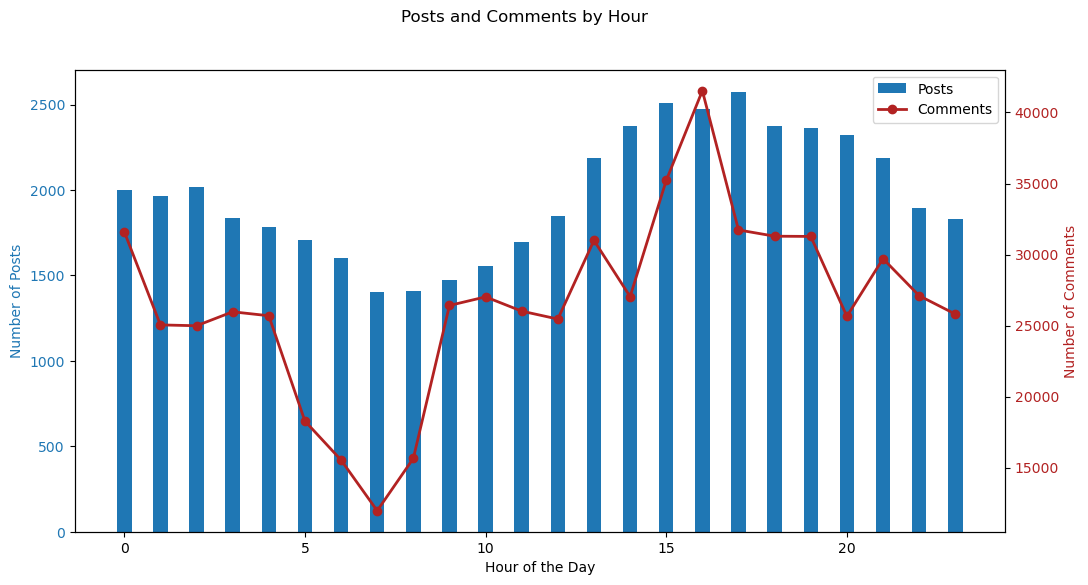

In [158]:
with plt.style.context(['science', 'high-vis']):
    # Configure plot settings
    plt.figure(figsize=(14, 7))
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.title_fontsize'] = 18
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.weight'] = 'normal'




fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for posts
ax1.bar(post_only_time_pd['hour'], post_only_time_pd['posts'], color='tab:blue', label='Posts', width=0.4)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Posts', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for comments
ax2 = ax1.twinx()
ax2.plot(post_only_time_pd['hour'], post_only_time_pd['comments'], color='firebrick', label='Comments', marker='o', linewidth=2)
ax2.set_ylabel('Number of Comments', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')

# Title and combined legend
fig.suptitle('Posts and Comments by Hour')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.savefig('../../website-source/plots/EDA/Q2/2_1.png')
plt.show()

### Posts and comments by day of week

In [72]:
post_only_day = posts_only.withColumn("datetime", to_timestamp(from_unixtime(col("created_utc"))))\
.withColumn("day_of_week", f.date_format("datetime", "E"))


In [73]:
post_only_day.show(5)

+---------+------+-----------+---------------+-------+------------+-----+---------+--------------------+-------------------+-----------+
|subreddit|    id|created_utc|         author|is_self|num_comments|score| selftext|               title|           datetime|day_of_week|
+---------+------+-----------+---------------+-------+------------+-----+---------+--------------------+-------------------+-----------+
| dogecoin|svxual| 1645233616|IEagleIwastaken|  false|          27|  400|         |     Super Doge Bros|2022-02-19 01:20:16|        Sat|
| dogecoin|t8z5h1| 1646686299|  kuriputonaito|  false|           4|   24|         |     SPARTANS ‼️‼️‼️|2022-03-07 20:51:39|        Mon|
| dogecoin|twz03j| 1649176504|    maximumkush|  false|           0|   15|         |Quick pup talk… h...|2022-04-05 16:35:04|        Tue|
| dogecoin|ueu9vv| 1651262591|  Particular408|  false|           6|   15|         |      Dog Not Single|2022-04-29 20:03:11|        Fri|
| dogecoin|wii23i| 1659885346|      [dele

In [75]:
post_only_day_pd = post_only_day .groupBy('day_of_week').agg(f.count("*").alias("posts"), \
                                   f.sum("num_comments").alias("comments")).orderBy(col("day_of_week")).toPandas()

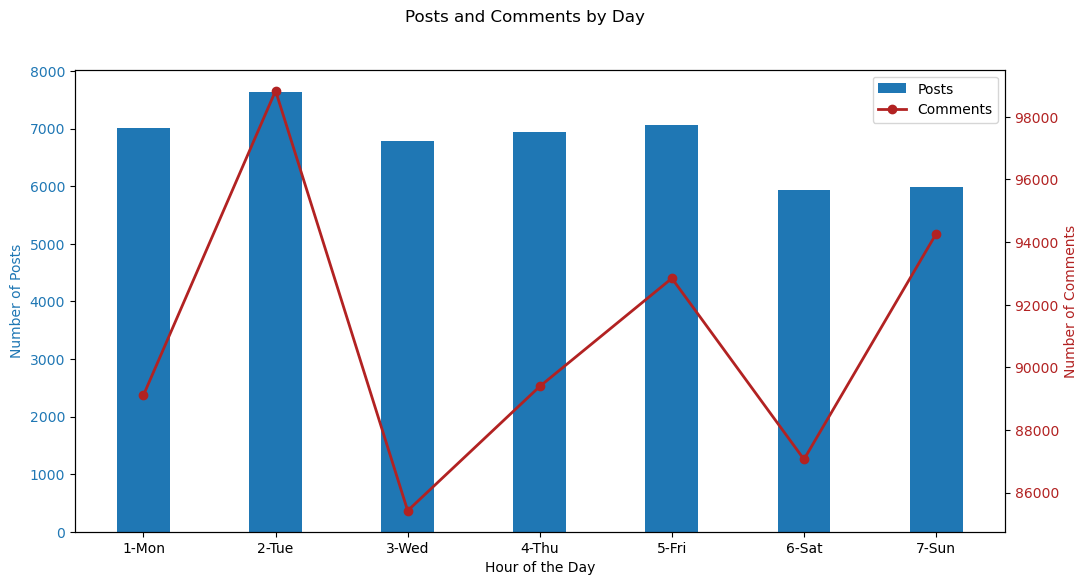

In [79]:
post_only_day_pd['day_of_week'] = post_only_day_pd['day_of_week'].replace({'Mon': '1-Mon', 'Tue': '2-Tue', 'Wed': '3-Wed',\
                                                                           'Thu': '4-Thu', 'Fri':'5-Fri', 'Sat':'6-Sat', 'Sun': '7-Sun'})
post_only_day_pd = post_only_day_pd.sort_values(by='day_of_week')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for posts
ax1.bar(post_only_day_pd['day_of_week'], post_only_day_pd['posts'], color='tab:blue', label='Posts', width=0.4)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Posts', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for comments
ax2 = ax1.twinx()
ax2.plot(post_only_day_pd['day_of_week'], post_only_day_pd['comments'], color='firebrick', label='Comments', marker='o', linewidth=2)
ax2.set_ylabel('Number of Comments', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')

# Title and combined legend
fig.suptitle('Posts and Comments by Day')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Network graph of users

In [86]:
posts_only_grp.show(5)

+---------+-----------+--------+-----------+
|subreddit|     author|comments|total_score|
+---------+-----------+--------+-----------+
| dogecoin|  [deleted]|   37104|     110683|
| dogecoin|  Links2586|    3186|      67279|
| dogecoin|  rizzo49er|    4941|      46276|
| dogecoin|KingCoin187|    6521|      28037|
| dogecoin|  Yellomelw|    3414|      25979|
+---------+-----------+--------+-----------+
only showing top 5 rows



In [87]:
posts_only_grp.count()

15761

In [88]:
comments_only_grp.show(5)

+--------------+----------+-----------+
| com_subreddit|com_author|total_score|
+--------------+----------+-----------+
|      dogecoin| [deleted]|     173364|
|      dogecoin| liquid_at|      24823|
|CryptoCurrency| [deleted]|      23386|
|      dogecoin|  Fulvio55|       7915|
|      dogecoin| sodogetip|       7385|
+--------------+----------+-----------+
only showing top 5 rows



In [90]:
comments_only_grp.count()

82125

In [92]:
# Combining posts and comments tables

comments_only_grp = comments_only_grp.withColumnRenamed("com_subreddit", "subreddit")\
         .withColumnRenamed("com_author", "author")


comments_only_grp = comments_only_grp.withColumn("comments", f.lit(None).cast("int"))


authors_df = posts_only_grp.unionByName(comments_only_grp)

authors_df.show(5)

+---------+-----------+--------+-----------+
|subreddit|     author|comments|total_score|
+---------+-----------+--------+-----------+
| dogecoin|  [deleted]|   37104|     110683|
| dogecoin|  Links2586|    3186|      67279|
| dogecoin|  rizzo49er|    4941|      46276|
| dogecoin|KingCoin187|    6521|      28037|
| dogecoin|  Yellomelw|    3414|      25979|
+---------+-----------+--------+-----------+
only showing top 5 rows



In [93]:
authors_df = authors_df.select('subreddit', 'author', 'total_score')

In [94]:
authors_df_uq = authors_df.groupBy('author').agg(f.sum('total_score').alias('ovr_score'))

In [95]:
authors_df_uq.count()

87744

In [160]:
# Select a subset of top authors

topn_score_authors = authors_df_uq.orderBy(col('ovr_score').desc()).limit(500) 

In [161]:
topn_score_authors_list = topn_score_authors.select("author").rdd.flatMap(lambda x: x).collect()

In [162]:
# Filter merged to include only top authors

filtered_df = merged.filter(
    col("author").isin(topn_score_authors_list) & col("com_author").isin(topn_score_authors_list))

In [163]:
# Filter out rows where 'author' or 'com_author' is None or '[deleted]' or both author cols are same
final_filtered_df = filtered_df.filter(
    (col("author").isNotNull()) & (col("com_author").isNotNull()) &
    (col("author") != "[deleted]") & (col("com_author") != "[deleted]") & (col("author") != col("com_author"))
)

In [110]:
final_filtered_df.show(5)

+---------+------------+-------+-----------+--------------------+-------+------------+-----+--------+--------------------+-------------+----------------+-------+---------------+---------------+-----------+---------+--------------------+-------------+
|subreddit|subreddit_id|     id|created_utc|              author|is_self|num_comments|score|selftext|               title|com_subreddit|com_subreddit_id| com_id|com_created_utc|     com_author|com_link_id|com_score|            com_body|com_submis_id|
+---------+------------+-------+-----------+--------------------+-------+------------+-----+--------+--------------------+-------------+----------------+-------+---------------+---------------+-----------+---------+--------------------+-------------+
| dogecoin|    t5_2zcp2|101a0ol| 1672657440|     cryptoheimdallr|  false|           3|   75|        |Dogecoin is the k...|     dogecoin|        t5_2zcp2|j2nc9o7|     1672678000|    MissGone300| t3_101a0ol|        2|           More DOGE|      101a0

In [164]:
final_filtered_df.count()

34595

In [165]:
edges_df = final_filtered_df.select("author", "com_author").distinct()

In [166]:
edges_df.count()

8364

In [114]:
edges_df.show(5)

24/04/04 20:38:07 WARN DAGScheduler: Broadcasting large task binary with size 1372.4 KiB


24/04/04 20:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1374.4 KiB
+-----------------+----------------+
|           author|      com_author|
+-----------------+----------------+
|        dashlukky| genericperson10|
|      Elrondarius|Evening_Two_9128|
|           agogie|    Therealboebs|
|DOGECOINBLACKBELT|    AntixianJUAR|
|   TheLegendofMrZ|       sodogetip|
+-----------------+----------------+
only showing top 5 rows



In [167]:
edges_pd = edges_df.toPandas()

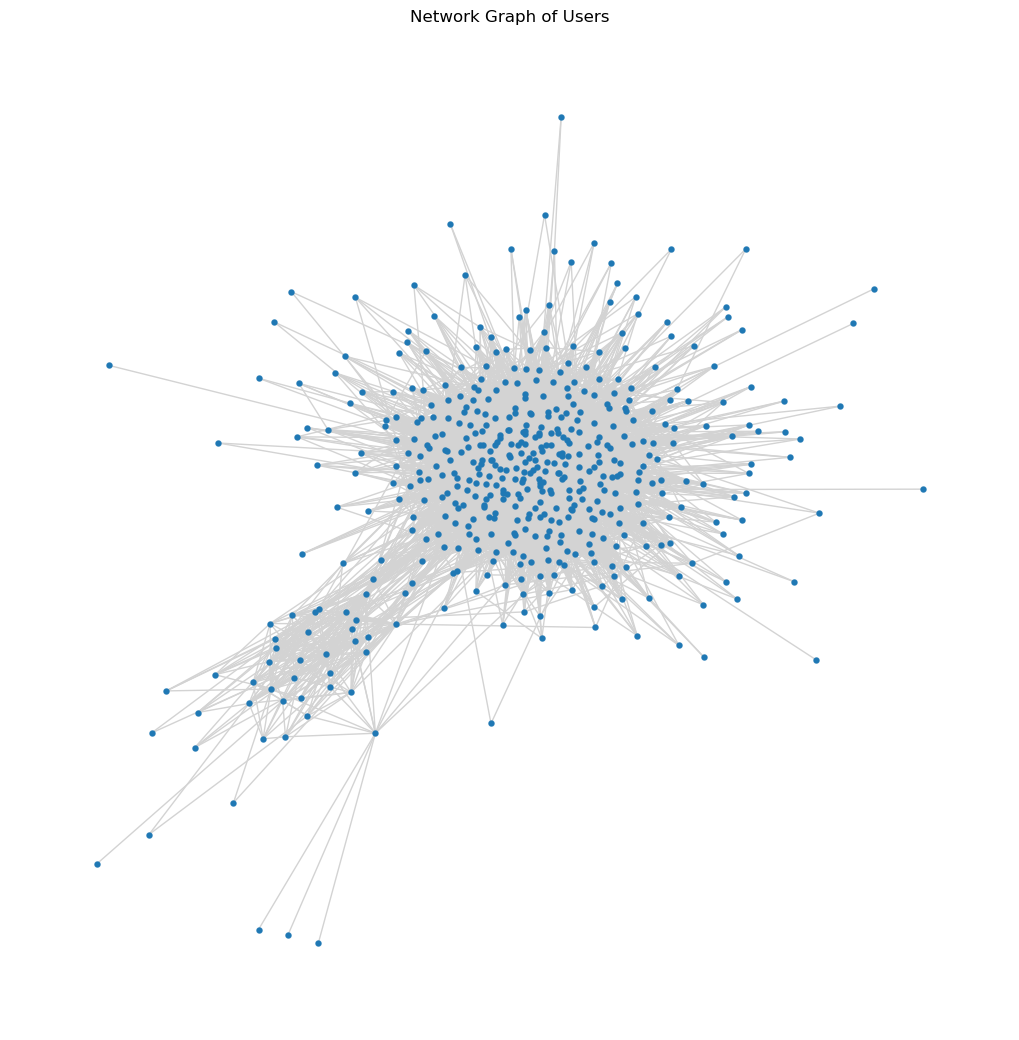

In [169]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the edge list
G = nx.from_pandas_edgelist(edges_pd, source="author", target="com_author")


plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=20, edge_color="lightgray", linewidths=0.1)
plt.title("Network Graph of Users")
plt.show()

### User stats table - Membership and activity across subreddits

In [80]:
user_stats = merged.select("id","created_utc", "author", "score","num_comments",\
              "com_created_utc","com_author","com_score")

In [81]:
# User stats for posts

user_stats_p = user_stats.select("id", "created_utc" , "author" , "score" , "num_comments").distinct()

In [82]:
# User stats for comments

user_stats_c = user_stats.select("com_created_utc", "com_author", "com_score")

In [83]:
# User stats - posts - tabulated

user_stats_p_t = user_stats_p.groupBy("author").agg(f.count("*").alias("n_posts"),\
                                   f.sum("num_comments").alias("n_comments_onposts"),\
                                                 f.round(f.avg("num_comments"), 2).alias("avg_cmnt_post"),
                                                    f.sum("score").alias("sum_score"),\
                                                    f.round(f.avg('score'), 2).alias('avg_score_post'))
           #                                       f.countDistinct('created_utc').alias('days_active_p'),
           #                                      f.min('created_utc').alias('first'),\
           #                                      f.max('created_utc').alias('last'))                                                 

In [84]:
user_stats_p_t.show(2)

+-------------+-------+------------------+-------------+---------+--------------+
|       author|n_posts|n_comments_onposts|avg_cmnt_post|sum_score|avg_score_post|
+-------------+-------+------------------+-------------+---------+--------------+
|chamberzation|      4|                 9|         2.25|       32|           8.0|
|      Jocogui|      1|                 0|          0.0|        1|           1.0|
+-------------+-------+------------------+-------------+---------+--------------+
only showing top 2 rows



In [85]:
# User stats - comments - tabulated

user_stats_c_t = user_stats_c.groupBy("com_author").agg(f.count("*").alias("n_comments"),\
                                                        f.sum("com_score").alias("sum_com_score"),\
                                                    f.round(f.avg('com_score'), 2).alias('avg_score_com'))
#                                                  f.countDistinct('com_created_utc').alias('days_active_c'),
#                                                 f.min('com_created_utc').alias('first'),\
#                                                 f.max('com_created_utc').alias('last'))                                                 

In [86]:
user_stats_c_t.show(2)

+-----------------+----------+-------------+-------------+
|       com_author|n_comments|sum_com_score|avg_score_com|
+-----------------+----------+-------------+-------------+
|challengergaming1|        27|          314|        11.63|
|           lz8001|         1|            1|          1.0|
+-----------------+----------+-------------+-------------+
only showing top 2 rows



In [87]:
# Join user stats - posts and comments tables

user_stats_join = user_stats_p_t.join(
    user_stats_c_t, (user_stats_p_t.author == user_stats_c_t.com_author), "outer")

In [88]:
user_stats_join.show(2)

+------+-------+------------------+-------------+---------+--------------+----------------+----------+-------------+-------------+
|author|n_posts|n_comments_onposts|avg_cmnt_post|sum_score|avg_score_post|      com_author|n_comments|sum_com_score|avg_score_com|
+------+-------+------------------+-------------+---------+--------------+----------------+----------+-------------+-------------+
|  null|   null|              null|         null|     null|          null|            null|     15893|         null|         null|
|  null|   null|              null|         null|     null|          null|----xxxzzzzzzzzz|         1|            2|          2.0|
+------+-------+------------------+-------------+---------+--------------+----------------+----------+-------------+-------------+
only showing top 2 rows



In [89]:
# Remove 'null' users and clean up table

user_stats_join_2 = user_stats_join.withColumn(
    "user",
    f.coalesce(f.col("author"), f.col("com_author"))).na.fill(0)\
.withColumn("n_activities", (col('n_posts') + col('n_comments')))\
.select('user', 'n_activities', 'n_posts','n_comments_onposts', 'avg_cmnt_post', 'sum_score',\
         'avg_score_post', 'n_comments', 'sum_com_score', 'avg_score_com').filter(col('user').isNotNull())

In [90]:
user_stats_join_2.count()

87743

In [91]:
user_stats_join_2.orderBy(col('n_posts').desc()).show(10)

+-----------------+------------+-------+------------------+-------------+---------+--------------+----------+-------------+-------------+
|             user|n_activities|n_posts|n_comments_onposts|avg_cmnt_post|sum_score|avg_score_post|n_comments|sum_com_score|avg_score_com|
+-----------------+------------+-------+------------------+-------------+---------+--------------+----------+-------------+-------------+
|        [deleted]|      183919|   7983|             40646|         5.09|   112146|         14.05|    175936|       196750|         1.12|
|        rizzo49er|        1006|    492|              4941|        10.04|    46276|         94.06|       514|          839|         1.63|
|         42points|         347|    279|             36774|       131.81|    11516|         41.28|        68|          240|         3.53|
|  SeaScarcity2110|         349|    277|              3181|        11.48|    17303|         62.47|        72|          208|         2.89|
|   TheDogeAcademy|         345|  

In [93]:
# Convert table to pandas

user_table_pd = user_stats_join_2.orderBy(col('n_posts').desc()).limit(10).toPandas()

In [113]:
# Isolate common users across both subreddits

common_users = appended_df.groupBy("author").agg(f.count("*").alias("count"))\
               .filter(col("count") > 1).withColumn("subreddit", f.lit('both')).select('subreddit', 'author')

In [114]:
common_users.distinct().count()

2782

In [115]:
common_users.show(5)

+---------+-----------------+
|subreddit|           author|
+---------+-----------------+
|     both| MuchDogeCurrency|
|     both|Money-Driver-7534|
|     both|  WicasaNapayshni|
|     both|      Johnny_ac3s|
|     both|        NangSal23|
+---------+-----------------+
only showing top 5 rows



In [98]:
common_users_list = common_users.select("author").rdd.flatMap(lambda x: x).collect()

In [107]:
# Isolate users who are part of one subreddit only

mono_users = appended_df.filter(~col("author").isin(common_users_list))


In [111]:
mono_users.show()

+---------+--------------------+
|subreddit|              author|
+---------+--------------------+
| dogecoin|           nanoeon20|
| dogecoin|        okokdogedoge|
| dogecoin|            Bigcrief|
| dogecoin|       Atexbymorning|
| dogecoin|        Steven_Ray20|
| dogecoin|         dogelovertr|
| dogecoin|     Fit_Culture2118|
| dogecoin|          lucivaryas|
| dogecoin|   AllofaSuddenStory|
| dogecoin|         OkDrink5993|
| dogecoin|             51oekim|
| dogecoin|      Entire_Toe6149|
| dogecoin|        Asparagus561|
| dogecoin|          thesean108|
| dogecoin|Intelligent-Judge304|
| dogecoin|      foreverloveyou|
| dogecoin|             makai99|
| dogecoin|Traditional-System10|
| dogecoin|    silversqueezer21|
| dogecoin|     One_Welder_9088|
+---------+--------------------+
only showing top 20 rows



In [116]:
# Table indicating subreddit/s each user is part of

user_channels = mono_users.unionByName(common_users)

In [117]:
user_channels.groupBy('subreddit').count().show()

+--------------+-----+
|     subreddit|count|
+--------------+-----+
|CryptoCurrency|23007|
|      dogecoin|61954|
|          both| 2782|
+--------------+-----+



In [118]:
user_channels.count()

87743

In [120]:
# Create a master table of user subreddit membership and activity stats

master_user = user_channels.join(user_stats_join_2, user_channels.author == user_stats_join_2.user, "inner")

In [121]:
master_user.count()

87743

In [130]:
master_user_df = master_user.groupBy('subreddit').agg(f.count("*").alias('n_users'),\
                                     f.sum('n_posts').alias('n_posts'),\
                                     f.sum('n_comments').alias('n_comments'),\
                                     f.round(f.avg('avg_score_post'), 2).alias('avg_score_posts'),\
                                     f.round(f.avg('avg_score_com'), 2).alias('avg_score_coms'))\
.withColumn('posts_per_user', f.round((col('n_posts') / col('n_users')), 2))\
.withColumn('coms_per_user', f.round((col('n_comments') / col('n_users')), 2))

In [132]:
master_user_df.show()

+--------------+-------+-------+----------+---------------+--------------+--------------+-------------+
|     subreddit|n_users|n_posts|n_comments|avg_score_posts|avg_score_coms|posts_per_user|coms_per_user|
+--------------+-------+-------+----------+---------------+--------------+--------------+-------------+
|CryptoCurrency|  23007|   1321|     67573|           2.69|          2.99|          0.06|         2.94|
|          both|   2782|  11845|    256874|           16.4|          2.99|          4.26|        92.33|
|      dogecoin|  61954|  34207|    247632|          10.02|          2.93|          0.55|          4.0|
+--------------+-------+-------+----------+---------------+--------------+--------------+-------------+

